# Building Grade Exploration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pwd

'/home/jovyan/work/src/data/research'

In [3]:
%cd ../../../

/home/jovyan/work


In [4]:
%pwd

'/home/jovyan/work'

In [5]:
import pandas as pd
from pathlib import Path
import plotly.express as px
from scipy.stats import percentileofscore

In [6]:
pd.set_option('display.float_format', '{:.4f}'.format)

In [7]:
data_dir = Path("src/data/dist")

In [8]:
df = pd.read_csv(data_dir / "building-benchmarks.csv")

In [9]:
df

DataYear      ID                            PropertyName  \
0         2022  100001      Presence SMEMC St Elizabeth Campus   
1         2020  100002      Clemente Community Academy HS -CPS   
2         2022  100019                          Dixon Building   
3         2022  100068                           Joffco Square   
4         2018  100148              The Jeffery Cyril Building   
...        ...     ...                                     ...   
3387      2022  260132                                  Q11970   
3388      2020  260135                                     NaN   
3389      2021  260149  Riverside Square & River's Edge/ 90033   
3390      2019  260150            Cummings Life Science Center   
3391      2022  260184                                     NaN   

     ReportingStatus                 Address ZIPCode  ChicagoEnergyRating  \
0     Submitted Data    1431 N Claremont Ave   60622                  NaN   
1     Submitted Data      1147 N Western Ave   60622               2.0000   
2     Submitted Data    411 - 415 S Wells St   60607               3.5000   
3     Submitted Data      555 W Roosevelt Rd   60607               2.0000   
4          Submitted  7144-48 S Jeffery Blvd   60649               1.0000   
...              ...                     ...     ...                  ...   
3387  Submitted Data         2401 W Grace St   60618               3.0000   
3388  Submitted Data          309  W 23RD ST   60616               4.0000   
3389       Submitted      3145 S Ashland Ave   60608               4.0000   
3390       Submitted           920 E 58th St   60637               2.0000   
3391  Submitted Data       2728 N HAMPDEN CT   60614               2.0000   

     ExemptFromChicagoEnergyRating   CommunityArea        PrimaryPropertyType  \
0                             True       WEST TOWN         Mixed Use Property   
1                            False       WEST TOWN                K-12 School   
2                            False            LOOP                     Office   
3                            False  NEAR WEST SIDE               Other - Mall   
4                            False     SOUTH SHORE        Multifamily Housing   
...                            ...             ...                        ...   
3387                         False    NORTH CENTER                     Office   
3388                         False   ARMOUR SQUARE        Multifamily Housing   
3389                         False   MCKINLEY PARK  Supermarket/Grocery Store   
3390                         False       HYDE PARK                 Laboratory   
3391                         False    LINCOLN PARK        Multifamily Housing   

      ...  SubmittedRecordsGrade  AvgPercentileGrade  \
0     ...                      A             31.9485   
1     ...                      B             42.3096   
2     ...                      A             52.1917   
3     ...                      A             47.6017   
4     ...                      F             13.1413   
...   ...                    ...                 ...   
3387  ...                      A             53.8263   
3388  ...                      B             53.8267   
3389  ...                      A             44.0570   
3390  ...                      A             42.4871   
3391  ...                      A             28.9277   

      AvgPercentileLetterGrade  GHGIntensityRankByPropertyType  \
0                            D                          5.0000   
1                            C                             NaN   
2                            C                        224.5000   
3                            C                          1.0000   
4                            F                             NaN   
...                        ...                             ...   
3387                         C                        130.0000   
3388                         C                             NaN   
3389                         C                  

In [10]:
# We drop these, because functions in this notebook were already used to generate these columns
# once in the .csv as part of the `process_data.py` script; so to start from scratch with this
# notebook, we should clean them out first:
grades_columns = [
        'AvgPercentileGrade',
        'AvgPercentileLetterGrade',
        'EnergyMixWeightedPctSum',
        'EnergyMixWeightedPctSumLetterGrade',
        'EnergyMixWeightedPctSumPercentileGrade',
        'GHGIntensityLetterGrade',
        'GHGIntensityPercentileGrade',
        'MissingRecordsCount',
        'MissingRecordsCountPercentileGrade',
        'SubmittedRecordsGrade',
    ]
df.drop(
    grades_columns,
    axis=1,
    inplace=True,
)

In [11]:
latest_year = df["DataYear"].max()
latest_year

2022

In [12]:
df_current = df.loc[df["DataYear"] == latest_year]
df_current.head()

DataYear      ID                        PropertyName ReportingStatus  \
0      2022  100001  Presence SMEMC St Elizabeth Campus  Submitted Data   
2      2022  100019                      Dixon Building  Submitted Data   
3      2022  100068                       Joffco Square  Submitted Data   
6      2022  100211                                 NaN  Submitted Data   
7      2022  100252                                 NaN  Submitted Data   

                 Address ZIPCode  ChicagoEnergyRating  \
0   1431 N Claremont Ave   60622                  NaN   
2   411 - 415 S Wells St   60607               3.5000   
3     555 W Roosevelt Rd   60607               2.0000   
6           73 E LAKE ST   60601               1.5000   
7  10426  S MICHIGAN AVE   60628               4.0000   

  ExemptFromChicagoEnergyRating   CommunityArea  PrimaryPropertyType  ...  \
0                          True       WEST TOWN   Mixed Use Property  ...   
2                         False            LOOP               Office  ...   
3                         False  NEAR WEST SIDE         Other - Mall  ...   
6                         False            LOOP  Multifamily Housing  ...   
7                         False        ROSELAND  Multifamily Housing  ...   

   SourceEUIPercentileRank  SiteEUIRank  SiteEUIPercentileRank  \
0                   0.9310     158.0000                 0.9380   
2                   0.4220    1519.0000                 0.4040   
3                   0.9440     484.0000                 0.8110   
6                   0.7540     859.5000                 0.6630   
7                   0.1820    2448.5000                 0.0400   

   GHGIntensityRankByPropertyType  TotalGHGEmissionsRankByPropertyType  \
0                          5.0000                              14.0000   
2                        224.5000                             303.0000   
3                          1.0000                               2.0000   
6                        165.5000                             194.0000   
7                       1095.0000                            1364.0000   

   ElectricityUseRankByPropertyType  NaturalGasUseRankByPropertyType  \
0                           15.0000                           9.0000   
2                          306.0000                         169.0000   
3                            2.0000                           3.0000   
6                          142.0000                         299.0000   
7                         1017.0000                        1375.0000   

   GrossFloorAreaRankByPropertyType  SourceEUIRankByPropertyType  \
0                           17.0000                       5.0000   
2                          315.0000                     231.0000   
3                            2.0000                       1.0000   
6                          218.0000                     158.5000   
7                         1400.0000                    1061.0000   

   SiteEUIRankByPropertyType  
0                     5.0000  
2                   145.0000  
3                     2.0000  
6                   379.5000  
7                  1348.5000  

[5 rows x 56 columns]

In [13]:
print(f"There are {df_current.shape[0]} records for {latest_year}.")

There are 2549 records for 2022.


In [14]:
df.columns

Index(['DataYear', 'ID', 'PropertyName', 'ReportingStatus', 'Address',
       'ZIPCode', 'ChicagoEnergyRating', 'ExemptFromChicagoEnergyRating',
       'CommunityArea', 'PrimaryPropertyType', 'GrossFloorArea', 'YearBuilt',
       'NumberOfBuildings', 'WaterUse', 'ENERGYSTARScore', 'ElectricityUse',
       'NaturalGasUse', 'DistrictSteamUse', 'DistrictChilledWaterUse',
       'AllOtherFuelUse', 'SiteEUI', 'SourceEUI', 'WeatherNormalizedSiteEUI',
       'WeatherNormalizedSourceEUI', 'TotalGHGEmissions', 'GHGIntensity',
       'Latitude', 'Longitude', 'Location', 'Row_ID', 'Wards',
       'CommunityAreas', 'ZipCodes', 'CensusTracts',
       'HistoricalWards2003-2015', 'GHGIntensityRank',
       'GHGIntensityPercentileRank', 'TotalGHGEmissionsRank',
       'TotalGHGEmissionsPercentileRank', 'ElectricityUseRank',
       'ElectricityUsePercentileRank', 'NaturalGasUseRank',
       'NaturalGasUsePercentileRank', 'GrossFloorAreaRank',
       'GrossFloorAreaPercentileRank', 'SourceEUIRank',
    

## EDA Brainstorm

### Number of Records by Property Type

In [15]:
df_current["PrimaryPropertyType"].unique()

array(['Mixed Use Property', 'Office', 'Other - Mall',
       'Multifamily Housing', 'K-12 School',
       'Hospital (General Medical & Surgical)', 'Retail Store', 'Hotel',
       'Strip Mall', 'Senior Living Community', 'College/University',
       'Convention Center', 'Financial Office', 'Enclosed Mall',
       'Other - Entertainment/Public Assembly',
       'Fitness Center/Health Club/Gym', 'Medical Office', 'Other',
       'Library', 'Museum', 'Laboratory', 'Prison/Incarceration',
       'Other - Specialty Hospital', 'Supermarket/Grocery Store',
       'Wholesale Club/Supercenter', 'Residential Care Facility',
       'Movie Theater', 'Data Center', 'Other - Services',
       'Vehicle Dealership', 'Other - Recreation', 'Distribution Center',
       'Residence Hall/Dormitory', 'Performing Arts',
       'Other - Public Services', 'Worship Facility',
       'Pre-school/Daycare', 'Other - Lodging/Residential',
       'Urgent Care/Clinic/Other Outpatient', 'Other - Education',
       'Ou

In [16]:
count_by_prop_type = df_current[["ID", "PrimaryPropertyType"]].groupby("PrimaryPropertyType").count().reset_index()
count_by_prop_type

PrimaryPropertyType    ID
0                              Adult Education     2
1                           College/University    67
2                            Convention Center     2
3                                   Courthouse     1
4                                  Data Center     4
5                          Distribution Center     1
6                                Enclosed Mall     5
7                             Financial Office     3
8               Fitness Center/Health Club/Gym    10
9        Hospital (General Medical & Surgical)    18
10                                       Hotel    72
11                            Ice/Curling Rink     1
12                                 K-12 School   315
13                                  Laboratory    15
14                                     Library     6
15                            Lifestyle Center     1
16                              Medical Office    13
17                          Mixed Use Property    32
18                               Movie Theater     4
19                         Multifamily Housing  1409
20                                      Museum     5
21                                      Office   327
22                                       Other    12
23                           Other - Education     1
24       Other - Entertainment/Public Assembly     3
25                 Other - Lodging/Residential     3
26                                Other - Mall     3
27                     Other - Public Services     3
28                          Other - Recreation     2
29                            Other - Services     1
30                  Other - Specialty Hospital     3
31  Outpatient Rehabilitation/Physical Therapy     4
32                             Performing Arts     7
33                          Pre-school/Daycare     2
34                        Prison/Incarceration     1
35                    Residence Hall/Dormitory     9
36                   Residential Care Facility    10
37                                Retail Store    37
38                     Senior Living Community    63
39                         Social/Meeting Hall     2
40                                  Strip Mall    19
41                   Supermarket/Grocery Store    36
42         Urgent Care/Clinic/Other Outpatient     1
43                          Vehicle Dealership     2
44                  Wholesale Club/Supercenter     5
45                            Worship Facility     7

In [17]:
count_by_prop_type.ID.min()

1

In [18]:
count_by_prop_type.ID.max()

1409

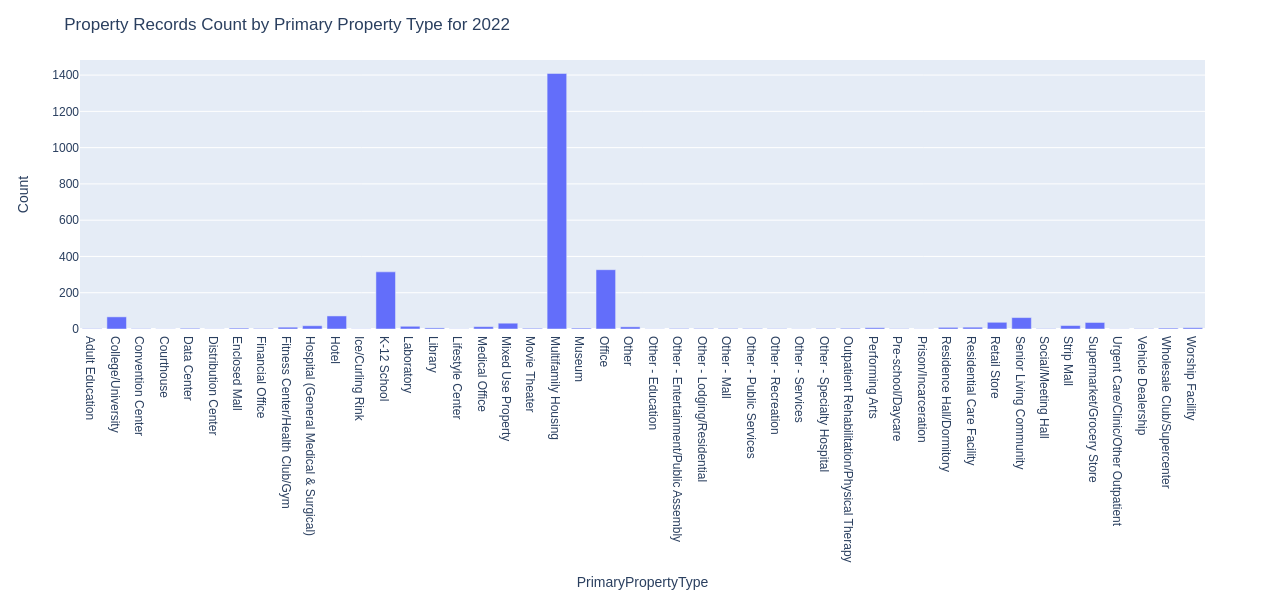

In [19]:
fig = px.bar(count_by_prop_type, x='PrimaryPropertyType', y='ID')

fig.update_layout(
    width=1200,
    height=600,
    title=f"Property Records Count by Primary Property Type for {latest_year}",
    yaxis_title='Count',
)

fig.show()

Conclusion: some categories are too sparse, so doing grading based on where a building stands compared to "peers" (same category) may be unreasonable. Unless we find data with corresponding categories but with more data points (e.g. national data).

## GHG Intensity Missingness and Distribution (Latest Year)

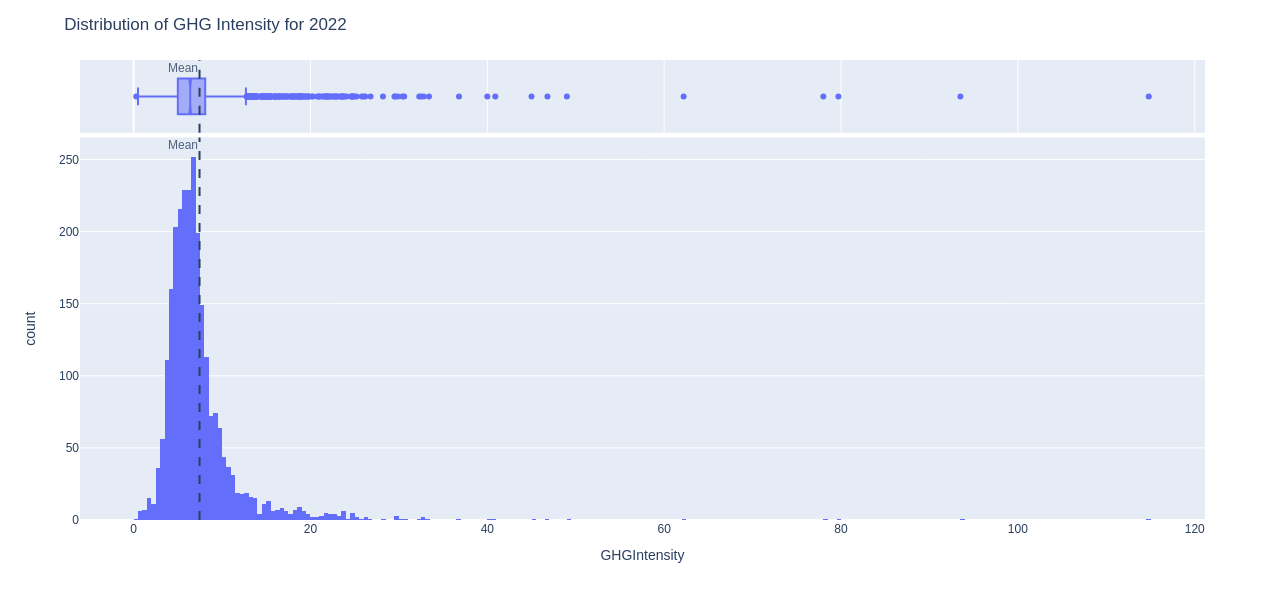

In [20]:
fig = px.histogram(
    df_current,
    x="GHGIntensity",
    marginal="box", # or violin, rug
    # hover_data=df.columns
)

# Calculate/graph mean
mean_value = df_current['GHGIntensity'].mean()
fig.add_vline(
    x=mean_value, 
    line_width=2, 
    line_dash="dash", 
    # line_color="red", 
    annotation_text="Mean", 
    annotation_position="top left",
    annotation=dict(
        text=f"Mean: {mean_value:.2f}",
        showarrow=False,
        x=mean_value,
        y=1,
        yref="paper",
        align="left",
        # bgcolor="red",
        opacity=0.8
    )
)

fig.update_layout(
    width=1200,
    height=600,
    title=f"Distribution of GHG Intensity for {latest_year}",
)

fig.show()

In [21]:
num_ghg_missing_latest_year = df_current['GHGIntensity'].isna().sum()
print(f"Number of records without GHGIntensity in {latest_year}: {num_ghg_missing_latest_year}")

Number of records without GHGIntensity in 2022: 0


## GHG Intensity Distribution by Property Type (Latest Year)

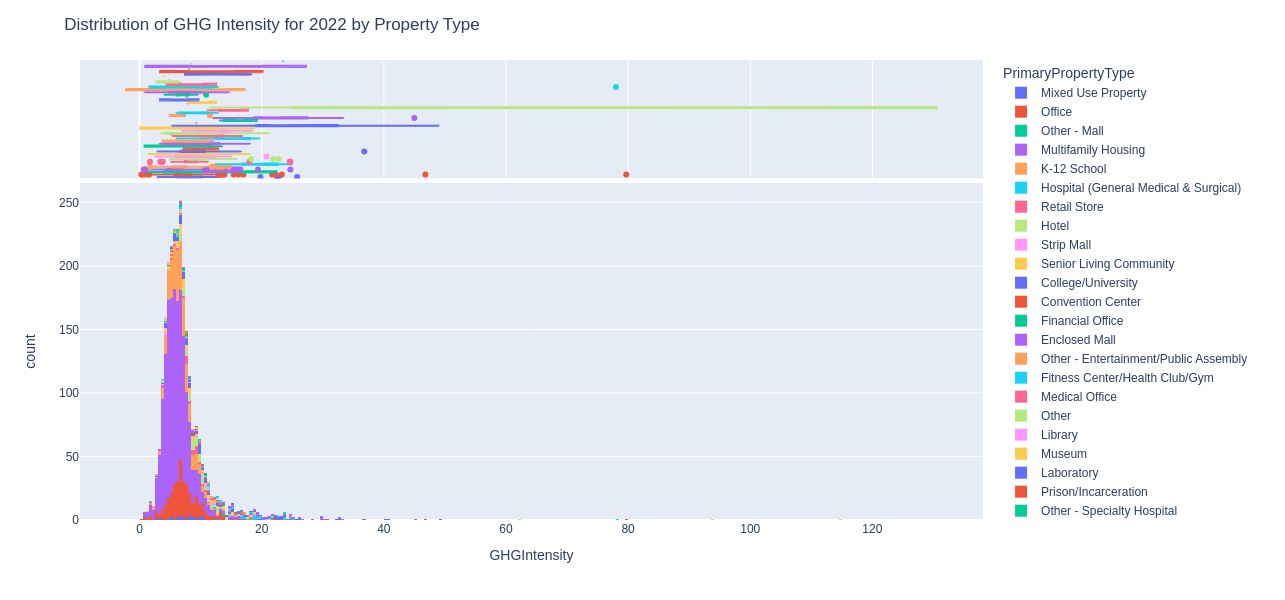

In [22]:
fig = px.histogram(
    df_current,
    x="GHGIntensity",
    marginal="box", # or violin, rug
    color="PrimaryPropertyType",
    # hover_data=df.columns
)


fig.update_layout(
    width=1200,
    height=600,
    title=f"Distribution of GHG Intensity for {latest_year} by Property Type",
)

fig.show()

## GHG Intensity vs Energy Star Rating (Latest Year)

In [23]:
missing_energy_star_num = df_current[["ENERGYSTARScore"]].isna().sum()
print(f"{missing_energy_star_num.iloc[0]} Energy Star Scores missing out of {df_current.shape[0]} for {latest_year}.")

310 Energy Star Scores missing out of 2549 for 2022.


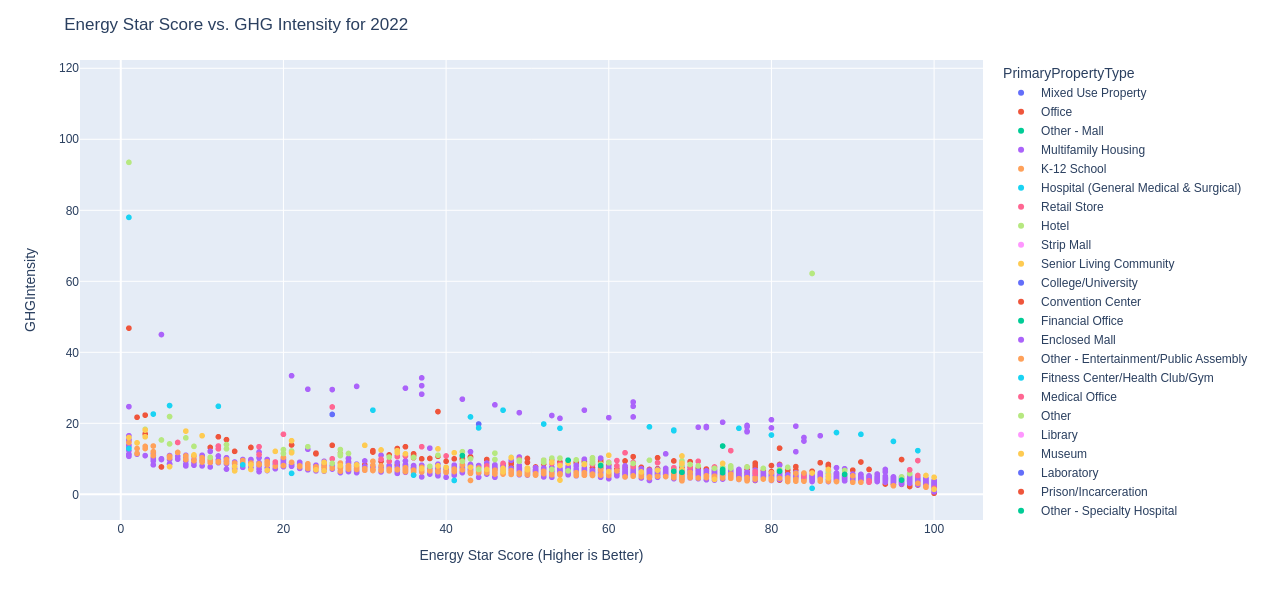

In [24]:
fig = px.scatter(
    df_current,
    y="GHGIntensity",
    x="ENERGYSTARScore",
    color="PrimaryPropertyType",
    hover_data=[
        "ID",
        "GHGIntensity",
        "ENERGYSTARScore",
        "PrimaryPropertyType"
    ],
)


fig.update_layout(
    width=1200,
    height=600,
    title=f"Energy Star Score vs. GHG Intensity for {latest_year}",
    xaxis_title='Energy Star Score (Higher is Better)',

    # hoverlabel=dict(
    #     bgcolor="white",
    #     font_size=16,
    #     font_family="Rockwell"
    # )
)

fig.show()

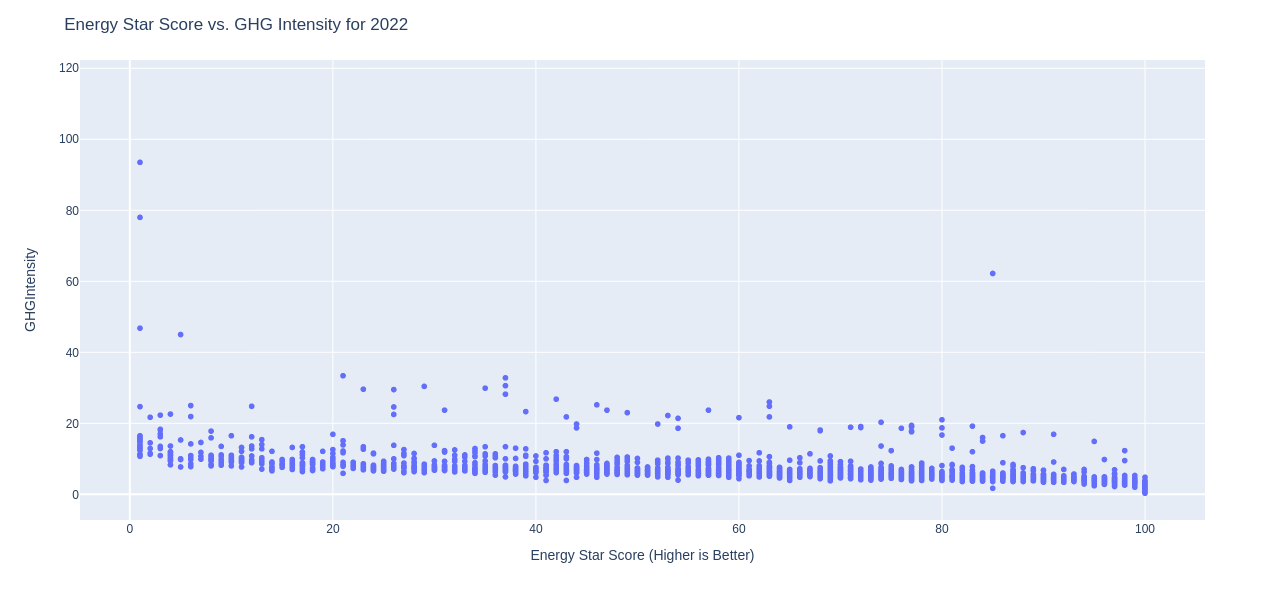

In [25]:
fig = px.scatter(
    df_current,
    y="GHGIntensity",
    x="ENERGYSTARScore",
    # color="PrimaryPropertyType",
    hover_data=[
        "ID",
        "GHGIntensity",
        "ENERGYSTARScore",
        # "PrimaryPropertyType"
    ],
)


fig.update_layout(
    width=1200,
    height=600,
    title=f"Energy Star Score vs. GHG Intensity for {latest_year}",
    xaxis_title='Energy Star Score (Higher is Better)',

    # hoverlabel=dict(
    #     bgcolor="white",
    #     font_size=16,
    #     font_family="Rockwell"
    # )
)

fig.show()

TODO: anomaly detection: new issue  
- across years; dramatic changes in GHG Intensity  
    - Flag anomalous data pre-grading  
    - by percentage change  
    - E.g. Maybe due to vacancy  
- 

In [26]:
correlation = df_current['ENERGYSTARScore'].corr(df_current['GHGIntensity'])

print(f"Correlation between ENERGYSTARScore and GHGIntensity: {correlation}")

Correlation between ENERGYSTARScore and GHGIntensity: -0.4845977490329846


Conclusion: Generally, higher Energy Star Score is (linearly) associated with lower GHG Intensity, as expected. But not all of GHG Intensity can be (linearly) explained by the Energy Star Score alone; about half is unaccounted for.

## Grading

### GHG Intensity

#### GHG Intensity Grade: Year-Based Percentile

Interpretation: Percentile grade of e.g. `56.3450` means that this building performs "better" than `56.3450%` of all buildings for the corresponding year.

Assign Grades:

In [27]:
from src.data.scripts.grade_buildings import generate_energy_int_grade

In [28]:
ghg_intensity_grades_df = generate_energy_int_grade(
    df=df, year=latest_year, cols_to_keep=["ID", "DataYear", "GHGIntensity"]
)
ghg_intensity_grades_df

ID  DataYear  GHGIntensity  GHGIntensityPercentileGrade  \
0     100001      2022       13.0000                       6.8262   
2     100019      2022        6.0000                      56.3750   
3     100068      2022       13.9000                       5.7670   
6     100211      2022        8.1000                      24.4802   
7     100252      2022        4.5000                      82.8953   
...      ...       ...           ...                          ...   
3383  260118      2022        4.2000                      87.0537   
3385  260127      2022        5.9000                      58.7681   
3386  260129      2022       10.7000                      11.0632   
3387  260132      2022        7.3000                      33.4641   
3391  260184      2022        7.8000                      26.9517   

     GHGIntensityLetterGrade  
0                          F  
2                          C  
3                          F  
6                          D  
7                          A  
...                      ...  
3383                       A  
3385                       C  
3386                       F  
3387                       D  
3391                       D  

[2549 rows x 5 columns]

##### Explore Grades:

###### GHG Intensity Percentile Grade Distribution

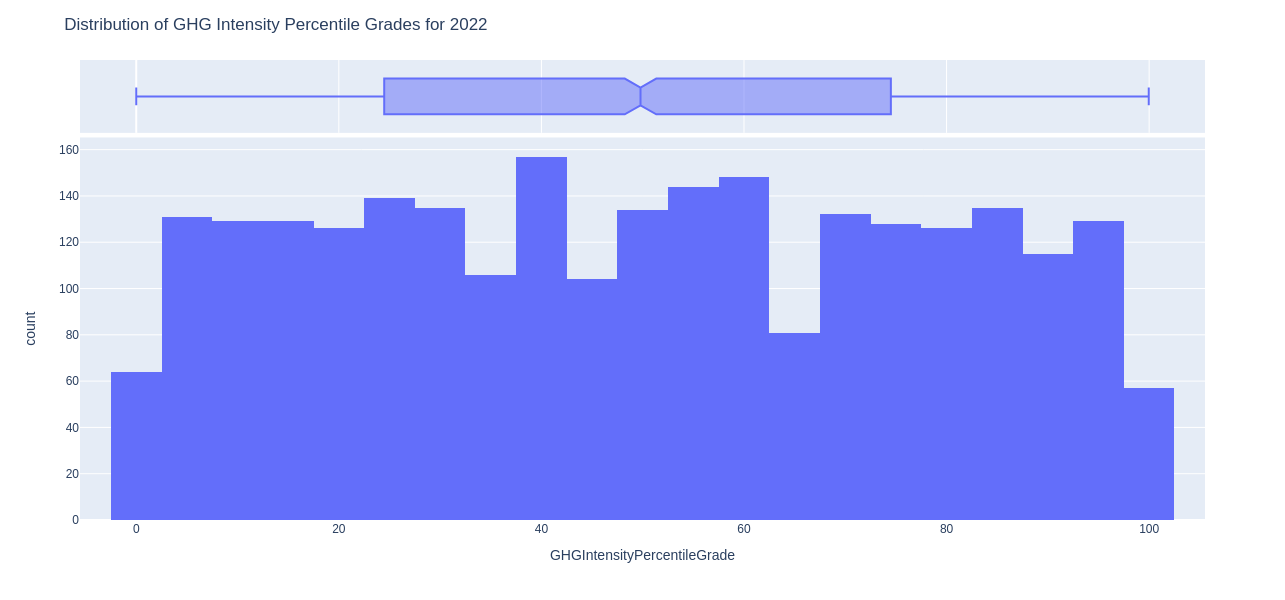

In [29]:
fig = px.histogram(
    ghg_intensity_grades_df,
    x="GHGIntensityPercentileGrade",
    marginal="box", # or violin, rug
)

fig.update_layout(
    width=1200,
    height=600,
    title=f"Distribution of GHG Intensity Percentile Grades for {latest_year}",
)

fig.show()

##### GHG Intensity Percentile Grade vs GHG Intensity

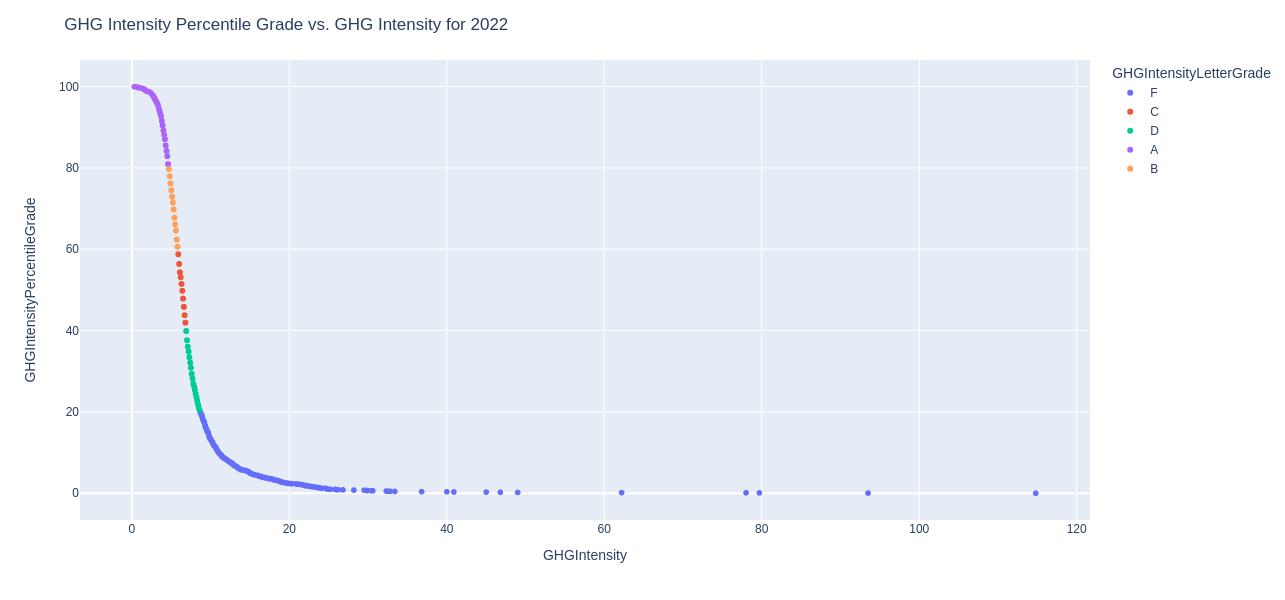

In [30]:
fig = px.scatter(
    ghg_intensity_grades_df,
    x="GHGIntensity",
    y="GHGIntensityPercentileGrade",
    color="GHGIntensityLetterGrade",
)

fig.update_layout(
    width=1200,
    height=600,
    title=f"GHG Intensity Percentile Grade vs. GHG Intensity for {latest_year}",
)

fig.show()
# TODO: link via ID in the tooltip or just by ID with `https://electrifychicago.net/building-id/:buildingId`

##### Grade GHG Intensity for All Years

In [31]:
from src.data.scripts.grade_buildings import apply_grade_func_all_years

In [32]:
ghg_intensity_grades_all_years_df = apply_grade_func_all_years(df=df, func=generate_energy_int_grade)
ghg_intensity_grades_all_years_df

ID  DataYear  GHGIntensityPercentileGrade GHGIntensityLetterGrade
0     100001      2022                       6.8262                       F
2     100019      2022                      56.3750                       C
3     100068      2022                       5.7670                       F
6     100211      2022                      24.4802                       D
7     100252      2022                      82.8953                       A
...      ...       ...                          ...                     ...
2271  251313      2016                      62.9630                       B
2297  251341      2016                      22.2222                       D
2312  251364      2016                      29.6296                       D
2923  253995      2016                      66.6667                       B
2985  254107      2016                      74.0741                       B

[3392 rows x 4 columns]

In [33]:
df.merge(ghg_intensity_grades_all_years_df, on=["ID", "DataYear"])

DataYear      ID                            PropertyName  \
0         2022  100001      Presence SMEMC St Elizabeth Campus   
1         2020  100002      Clemente Community Academy HS -CPS   
2         2022  100019                          Dixon Building   
3         2022  100068                           Joffco Square   
4         2018  100148              The Jeffery Cyril Building   
...        ...     ...                                     ...   
3387      2022  260132                                  Q11970   
3388      2020  260135                                     NaN   
3389      2021  260149  Riverside Square & River's Edge/ 90033   
3390      2019  260150            Cummings Life Science Center   
3391      2022  260184                                     NaN   

     ReportingStatus                 Address ZIPCode  ChicagoEnergyRating  \
0     Submitted Data    1431 N Claremont Ave   60622                  NaN   
1     Submitted Data      1147 N Western Ave   60622               2.0000   
2     Submitted Data    411 - 415 S Wells St   60607               3.5000   
3     Submitted Data      555 W Roosevelt Rd   60607               2.0000   
4          Submitted  7144-48 S Jeffery Blvd   60649               1.0000   
...              ...                     ...     ...                  ...   
3387  Submitted Data         2401 W Grace St   60618               3.0000   
3388  Submitted Data          309  W 23RD ST   60616               4.0000   
3389       Submitted      3145 S Ashland Ave   60608               4.0000   
3390       Submitted           920 E 58th St   60637               2.0000   
3391  Submitted Data       2728 N HAMPDEN CT   60614               2.0000   

     ExemptFromChicagoEnergyRating   CommunityArea        PrimaryPropertyType  \
0                             True       WEST TOWN         Mixed Use Property   
1                            False       WEST TOWN                K-12 School   
2                            False            LOOP                     Office   
3                            False  NEAR WEST SIDE               Other - Mall   
4                            False     SOUTH SHORE        Multifamily Housing   
...                            ...             ...                        ...   
3387                         False    NORTH CENTER                     Office   
3388                         False   ARMOUR SQUARE        Multifamily Housing   
3389                         False   MCKINLEY PARK  Supermarket/Grocery Store   
3390                         False       HYDE PARK                 Laboratory   
3391                         False    LINCOLN PARK        Multifamily Housing   

      ...  SiteEUIPercentileRank  GHGIntensityRankByPropertyType  \
0     ...                 0.9380                          5.0000   
1     ...                    NaN                             NaN   
2     ...                 0.4040                        224.5000   
3     ...                 0.8110                          1.0000   
4     ...                    NaN                             NaN   
...   ...                    ...                             ...   
3387  ...                 0.3930                        130.0000   
3388  ...                    NaN                             NaN   
3389  ...                    NaN                             NaN   
3390  ...                    NaN                             NaN   
3391  ...                 0.8480                        200.0000   

      TotalGHGEmissionsRankByPropertyType  ElectricityUseRankByPropertyType  \
0                                 14.0000                           15.0000   
1                                     NaN                               NaN   
2                                303.0000                          306.0000   
3                                  2.0000                            2.0000   
4                                     NaN                               NaN   
...                     

##### Limitations of this grading method:

- Is not a peer-to-peer comparison; e.g. a 24/7 hospital would be graded with the same methodology as an office building.
- Even if all buildings as a whole emit less and less GHG year-over-year, there will always be the same proportion of them in each letter grade category within each given year. I.e. there will always be 1/5 of building receiving each particular grade within each year => should there be instead a reference (index/benchmark) year? Or a different grading methodology that accounts for improvement over time?
- An alternative: do similar to Energy Star Scores: calculate a building's expected GHG Intensity via OLS linear regression based on its peers, then do ratio between actual GHG Intensity and its predicted value, then do percentile score. OLS can be run using [Building Performance Database (BPD) Application Programming Interface (API)](https://buildings.lbl.gov/cbs/bpd-api-documentation/).

### Energy Mix

#### Energy Mix Grade: Simple Arbitrary Weight Score

Interpretation: Percentile grade of e.g. `56.3450` means that this building performs "better" than `56.3450%` of all buildings for the corresponding year. The score used for the Percentile Grade calculation is a weighted sum of percentages of each energy source for a corresponding building. 

In [34]:
from src.data.scripts.grade_buildings import generate_energymix_grade

In [35]:
energymix_cols_to_keep = [
    "ID",
    "DataYear",
    "ElectricityUse",
    "NaturalGasUse",
    "DistrictSteamUse",
    "DistrictChilledWaterUse",
    "AllOtherFuelUse"
]
energymix_grades_df = generate_energymix_grade(df, year=2022, cols_to_keep=energymix_cols_to_keep)
energymix_grades_df

ID  DataYear  ElectricityUse  NaturalGasUse  DistrictSteamUse  \
0     100001      2022   16795066.2000  33899078.5000            0.0000   
2     100019      2022    1641381.8000   2465232.2000            0.0000   
3     100068      2022    8354489.4000    331613.0000            0.0000   
6     100211      2022   12253233.4000  14931549.6000            0.0000   
7     100252      2022    1550327.6000    110041.9000            0.0000   
...      ...       ...             ...            ...               ...   
3383  260118      2022     669935.5000   3679236.0000            0.0000   
3385  260127      2022    7924051.9000   3717569.9000            0.0000   
3386  260129      2022    2750911.1000   3444364.9000            0.0000   
3387  260132      2022    4204386.8000   2280683.7000            0.0000   
3391  260184      2022    3070202.6000  12991299.7000            0.0000   

      DistrictChilledWaterUse  AllOtherFuelUse  EnergyMixWeightedPctSum  \
0                      0.0000              NaN                  99.6953   
2                      0.0000              NaN                 109.9538   
3                      0.0000              NaN                 194.2734   
6                      0.0000              NaN                 117.6108   
7                      0.0000              NaN                 190.0587   
...                       ...              ...                      ...   
3383                   0.0000              NaN                  73.1056   
3385                   0.0000              NaN                 152.0998   
3386                   0.0000              NaN                 116.6050   
3387                   0.0000              NaN                 147.2477   
3391                   0.0000              NaN                  78.6729   

      EnergyMixWeightedPctSumPercentileGrade  \
0                                    45.1942   
2                                    56.3750   
3                                    93.2130   
6                                    63.7897   
7                                    92.8207   
...                                      ...   
3383                                  9.0231   
3385                                 85.5237   
3386                                 63.0051   
3387                                 84.1899   
3391                                 16.0063   

     EnergyMixWeightedPctSumLetterGrade  
0                                     C  
2                                     C  
3                                     A  
6                                     B  
7                                     A  
...                                 ...  
3383                                  F  
3385                                  A  
3386                                  B  
3387                                  A  
3391                                  F  

[2549 rows x 10 columns]

##### Explore Grades:

In [36]:
# TODO

##### Grade All Years for Energy Mix Grade:

In [37]:
energy_mix_grades_all_years_df = apply_grade_func_all_years(df=df, func=generate_energymix_grade)
energy_mix_grades_all_years_df

ID  DataYear  EnergyMixWeightedPctSum  \
0     100001      2022                  99.6953   
2     100019      2022                 109.9538   
3     100068      2022                 194.2734   
6     100211      2022                 117.6108   
7     100252      2022                 190.0587   
...      ...       ...                      ...   
2271  251313      2016                  63.4605   
2297  251341      2016                 181.9399   
2312  251364      2016                 111.2246   
2923  253995      2016                 131.8725   
2985  254107      2016                 109.7691   

      EnergyMixWeightedPctSumPercentileGrade  \
0                                    45.1942   
2                                    56.3750   
3                                    93.2130   
6                                    63.7897   
7                                    92.8207   
...                                      ...   
2271                                 18.5185   
2297                                 88.8889   
2312                                 55.5556   
2923                                 70.3704   
2985                                 51.8519   

     EnergyMixWeightedPctSumLetterGrade  
0                                     C  
2                                     C  
3                                     A  
6                                     B  
7                                     A  
...                                 ...  
2271                                  F  
2297                                  A  
2312                                  C  
2923                                  B  
2985                                  C  

[3392 rows x 5 columns]

In [38]:
df.merge(energy_mix_grades_all_years_df, on=["ID", "DataYear"])

DataYear      ID                            PropertyName  \
0         2022  100001      Presence SMEMC St Elizabeth Campus   
1         2020  100002      Clemente Community Academy HS -CPS   
2         2022  100019                          Dixon Building   
3         2022  100068                           Joffco Square   
4         2018  100148              The Jeffery Cyril Building   
...        ...     ...                                     ...   
3387      2022  260132                                  Q11970   
3388      2020  260135                                     NaN   
3389      2021  260149  Riverside Square & River's Edge/ 90033   
3390      2019  260150            Cummings Life Science Center   
3391      2022  260184                                     NaN   

     ReportingStatus                 Address ZIPCode  ChicagoEnergyRating  \
0     Submitted Data    1431 N Claremont Ave   60622                  NaN   
1     Submitted Data      1147 N Western Ave   60622               2.0000   
2     Submitted Data    411 - 415 S Wells St   60607               3.5000   
3     Submitted Data      555 W Roosevelt Rd   60607               2.0000   
4          Submitted  7144-48 S Jeffery Blvd   60649               1.0000   
...              ...                     ...     ...                  ...   
3387  Submitted Data         2401 W Grace St   60618               3.0000   
3388  Submitted Data          309  W 23RD ST   60616               4.0000   
3389       Submitted      3145 S Ashland Ave   60608               4.0000   
3390       Submitted           920 E 58th St   60637               2.0000   
3391  Submitted Data       2728 N HAMPDEN CT   60614               2.0000   

     ExemptFromChicagoEnergyRating   CommunityArea        PrimaryPropertyType  \
0                             True       WEST TOWN         Mixed Use Property   
1                            False       WEST TOWN                K-12 School   
2                            False            LOOP                     Office   
3                            False  NEAR WEST SIDE               Other - Mall   
4                            False     SOUTH SHORE        Multifamily Housing   
...                            ...             ...                        ...   
3387                         False    NORTH CENTER                     Office   
3388                         False   ARMOUR SQUARE        Multifamily Housing   
3389                         False   MCKINLEY PARK  Supermarket/Grocery Store   
3390                         False       HYDE PARK                 Laboratory   
3391                         False    LINCOLN PARK        Multifamily Housing   

      ...  GHGIntensityRankByPropertyType  \
0     ...                          5.0000   
1     ...                             NaN   
2     ...                        224.5000   
3     ...                          1.0000   
4     ...                             NaN   
...   ...                             ...   
3387  ...                        130.0000   
3388  ...                             NaN   
3389  ...                             NaN   
3390  ...                             NaN   
3391  ...                        200.0000   

      TotalGHGEmissionsRankByPropertyType  ElectricityUseRankByPropertyType  \
0                                 14.0000                           15.0000   
1                                     NaN                               NaN   
2                                303.0000                          306.0000   
3                                  2.0000                            2.0000   
4                                     NaN                               NaN   
...                                   ...                               ...   
3387                             257.0000                          245.0000   
3388                                  NaN                               NaN   
3389                                  NaN                      

#### [WIP] Energy Mix Grade: Score Weighted Using GHG Emission Factor 

Interpretation: Same as the Simple Arbitrary Weight Score above, except weights are calculated off of the GHG Emission factos used by Energy Star.

These data are from [`Energy Star's Historical Greenhouse Gas Factors, 2000 – present`](https://www.energystar.gov/buildings/tools-and-resources/historical-greenhouse-gas-factors-2000-present). When the `Subregion` is `NaN`, Energy Uses the national factor (i.e. no division by subregion for those energy sources).

In [39]:
data_dir

PosixPath('src/data/dist')

In [40]:
basic_rows_to_skip = [0, 1, 2]

direct_ghg_emissions_factors_df = pd.read_excel(
    "src/data/research/data/Historical_GHG_Factors.xlsx",
    sheet_name="US Emission Factors",
    usecols="A:AA",
    skiprows=basic_rows_to_skip + [4],
    nrows=11,
)

direct_ghg_emissions_factors_df

Fuel Type  Subregion     2000     2001     2002     2003  \
0                Natural Gas        NaN  53.0720  53.0720  53.0720  53.0720   
1                    Propane        NaN  61.4956  61.4956  61.4956  61.4956   
2           Fuel Oil (No. 1)        NaN  73.4990  73.4990  73.4990  73.4990   
3           Fuel Oil (No. 2)        NaN  74.2090  74.2090  74.2090  74.2090   
4           Fuel Oil (No. 4)        NaN  75.2890  75.2890  75.2890  75.2890   
5   Fuel Oil (No. 5 & No. 6)        NaN  75.3490  75.3490  75.3490  75.3490   
6                     Diesel        NaN  74.2090  74.2090  74.2090  74.2090   
7          Coal (anthracite)        NaN 104.2670 104.2670 104.2670 104.2670   
8          Coal (bituminous)        NaN  94.1270  94.1270  94.1270  94.1270   
9                       Coke        NaN 102.7670 102.7670 102.7670 102.7670   
10                  Kerosene        NaN  77.6900  77.6900  77.6900  77.6900   

       2004     2005     2006     2007  ...     2015     2016     2017  \
0   53.0720  53.0720  53.0720  53.0720  ...  53.1148  53.1148  53.1148   
1   61.4956  61.4956  61.4956  61.4956  ...  64.2480  64.2480  64.2480   
2   73.4990  73.4990  73.4990  73.4990  ...  73.4990  73.4990  73.4990   
3   74.2090  74.2090  74.2090  74.2090  ...  74.2090  74.2090  74.2090   
4   75.2890  75.2890  75.2890  75.2890  ...  75.2890  75.2890  75.2890   
5   75.3490  75.3490  75.3490  75.3490  ...  75.3490  75.3490  75.3490   
6   74.2090  74.2090  74.2090  74.2090  ...  74.2090  74.2090  74.2090   
7  104.2670 104.2670 104.2670 104.2670  ... 104.4418 104.4418 104.4418   
8   94.1270  94.1270  94.1270  94.1270  ...  94.0318  94.0318  94.0318   
9  102.7670 102.7670 102.7670 102.7670  ... 114.4218 114.4218 114.4218   
10  77.6900  77.6900  77.6900  77.6900  ...  77.6900  77.6900  77.6900   

       2018     2019     2020     2021     2022     2023     2024  
0   53.1148  53.1148  53.1148  53.1148  53.1145  53.1145  53.1145  
1   64.2480  64.2480  64.2480  64.2480  61.9530  61.9530  61.9530  
2   73.4990  73.4990  73.4990  73.4990  73.4930  73.4930  73.4930  
3   74.2090  74.2090  74.2090  74.2090  74.2030  74.2030  74.2030  
4   75.2890  75.2890  75.2890  75.2890  75.2830  75.2830  75.2830  
5   75.3490  75.3490  75.3490  75.3490  74.2580  74.2580  74.2580  
6   74.2090  74.2090  74.2090  74.2090  75.1630  75.1630  75.1630  
7  104.4418 104.4418 104.4418 104.4418 104.4220 104.4220 104.4220  
8   94.0318  94.0318  94.0318  94.0318  94.0120  94.0120  94.0120  
9  114.4218 114.4218 114.4218 114.4218 114.4020 114.4020 114.4020  
10  77.6900  77.6900  77.6900  77.6900  75.4430  75.4430  75.4430  

[11 rows x 27 columns]

In [41]:
indirect_ghg_emissions_district_fuels_df = pd.read_excel(
    "src/data/research/data/Historical_GHG_Factors.xlsx",
    sheet_name="US Emission Factors",
    usecols="A:AA",
    skiprows=basic_rows_to_skip + list(range(basic_rows_to_skip[-1] + 2, 17)),
    nrows=5,
)

indirect_ghg_emissions_district_fuels_df

Fuel Type  Subregion    2000  \
0                                     District Steam        NaN 88.5385   
1                                 District Hot Water        NaN 88.5385   
2   District Chilled Water - Electric Driven Chiller        NaN 52.7047   
3  District Chilled Water - Absorption Chiller us...        NaN 73.8636   
4  District Chilled Water - Engine-Driven Chiller...        NaN 49.2905   

     2001    2002    2003    2004    2005    2006    2007  ...    2015  \
0 88.5385 88.5385 88.5385 88.5385 88.5385 88.5385 88.5385  ... 66.3985   
1 88.5385 88.5385 88.5385 88.5385 88.5385 88.5385 88.5385  ... 66.3985   
2 52.7047 52.7047 52.7047 52.7047 52.7047 52.7047 52.7047  ... 52.7004   
3 73.8636 73.8636 73.8636 73.8636 73.8636 73.8636 73.8636  ... 73.8893   
4 49.2905 49.2905 49.2905 49.2905 49.2905 49.2905 49.2905  ... 49.3082   

     2016    2017    2018    2019    2020    2021    2022    2023    2024  
0 66.3985 66.3985 66.3985 66.3985 66.3985 66.3985 66.3985 66.3985 66.3985  
1 66.3985 66.3985 66.3985 66.3985 66.3985 66.3985 66.3985 66.3985 66.3985  
2 52.7004 52.7004 52.7004 52.7004 52.7004 52.7004 52.7004 52.7004 52.7004  
3 73.8893 73.8893 73.8893 73.8893 73.8893 73.8893 73.8893 73.8893 73.8893  
4 49.3082 49.3082 49.3082 49.3082 49.3082 49.3082 49.3082 49.3082 49.3082  

[5 rows x 27 columns]

In [42]:
biomass_ghg_emissions_district_fuels_df = pd.read_excel(
    "src/data/research/data/Historical_GHG_Factors.xlsx",
    sheet_name="US Emission Factors",
    usecols="A:AA",
    skiprows=basic_rows_to_skip + list(range(basic_rows_to_skip[-1] + 2, 23)),
    nrows=1,
)

biomass_ghg_emissions_district_fuels_df

Fuel Type  Subregion    2000    2001    2002    2003    2004    2005  \
0      Wood        NaN 95.7740 95.7740 95.7740 95.7740 95.7740 95.7740   

     2006    2007  ...    2015    2016    2017    2018    2019    2020  \
0 95.7740 95.7740  ... 95.0528 94.2227 94.2227 95.0528 95.0528 95.0528   

     2021    2022    2023    2024  
0 95.0528 94.9556 94.9556 94.9556  

[1 rows x 27 columns]

In [43]:
# Chicago is in RFCW subregion, based on https://portfoliomanager.energystar.gov/pdf/reference/Emissions.pdf
indirect_ghg_emissions_electricity_df = pd.read_excel(
    "src/data/research/data/Historical_GHG_Factors.xlsx",
    sheet_name="US Emission Factors",
    usecols="A:AA",
    skiprows=basic_rows_to_skip + list(range(basic_rows_to_skip[-1] + 2, 25)),
    nrows=28,
)
indirect_ghg_emissions_electricity_df = indirect_ghg_emissions_electricity_df.loc[indirect_ghg_emissions_electricity_df["Subregion"] == "RFCW"]
indirect_ghg_emissions_electricity_df

Fuel Type Subregion     2000     2001     2002     2003     2004  \
18  Electricity - Grid      RFCW 205.5095 205.5095 205.5095 205.5095 205.5095   

       2005     2006     2007  ...     2015     2016     2017     2018  \
18 205.5095 205.5095 207.3702  ... 184.8948 166.3642 166.3642 156.0693   

       2019     2020     2021     2022     2023     2024  
18 142.8265 131.7142 139.9196 133.7058 133.7058 133.7058  

[1 rows x 27 columns]

In [44]:
# Combine all GHG Emission factors into a single DF for ease of handling:
emission_factors_dfs = [
    direct_ghg_emissions_factors_df,
    indirect_ghg_emissions_district_fuels_df,
    biomass_ghg_emissions_district_fuels_df,
    indirect_ghg_emissions_electricity_df,
]
emission_factors_df = pd.concat(emission_factors_dfs).reset_index(drop=True)
emission_factors_df

Fuel Type Subregion     2000  \
0                                         Natural Gas       NaN  53.0720   
1                                             Propane       NaN  61.4956   
2                                    Fuel Oil (No. 1)       NaN  73.4990   
3                                    Fuel Oil (No. 2)       NaN  74.2090   
4                                    Fuel Oil (No. 4)       NaN  75.2890   
5                            Fuel Oil (No. 5 & No. 6)       NaN  75.3490   
6                                              Diesel       NaN  74.2090   
7                                   Coal (anthracite)       NaN 104.2670   
8                                   Coal (bituminous)       NaN  94.1270   
9                                                Coke       NaN 102.7670   
10                                           Kerosene       NaN  77.6900   
11                                     District Steam       NaN  88.5385   
12                                 District Hot Water       NaN  88.5385   
13   District Chilled Water - Electric Driven Chiller       NaN  52.7047   
14  District Chilled Water - Absorption Chiller us...       NaN  73.8636   
15  District Chilled Water - Engine-Driven Chiller...       NaN  49.2905   
16                                               Wood       NaN  95.7740   
17                                 Electricity - Grid      RFCW 205.5095   

       2001     2002     2003     2004     2005     2006     2007  ...  \
0   53.0720  53.0720  53.0720  53.0720  53.0720  53.0720  53.0720  ...   
1   61.4956  61.4956  61.4956  61.4956  61.4956  61.4956  61.4956  ...   
2   73.4990  73.4990  73.4990  73.4990  73.4990  73.4990  73.4990  ...   
3   74.2090  74.2090  74.2090  74.2090  74.2090  74.2090  74.2090  ...   
4   75.2890  75.2890  75.2890  75.2890  75.2890  75.2890  75.2890  ...   
5   75.3490  75.3490  75.3490  75.3490  75.3490  75.3490  75.3490  ...   
6   74.2090  74.2090  74.2090  74.2090  74.2090  74.2090  74.2090  ...   
7  104.2670 104.2670 104.2670 104.2670 104.2670 104.2670 104.2670  ...   
8   94.1270  94.1270  94.1270  94.1270  94.1270  94.1270  94.1270  ...   
9  102.7670 102.7670 102.7670 102.7670 102.7670 102.7670 102.7670  ...   
10  77.6900  77.6900  77.6900  77.6900  77.6900  77.6900  77.6900  ...   
11  88.5385  88.5385  88.5385  88.5385  88.5385  88.5385  88.5385  ...   
12  88.5385  88.5385  88.5385  88.5385  88.5385  88.5385  88.5385  ...   
13  52.7047  52.7047  52.7047  52.7047  52.7047  52.7047  52.7047  ...   
14  73.8636  73.8636  73.8636  73.8636  73.8636  73.8636  73.8636  ...   
15  49.2905  49.2905  49.2905  49.2905  49.2905  49.2905  49.2905  ...   
16  95.7740  95.7740  95.7740  95.7740  95.7740  95.7740  95.7740  ...   
17 205.5095 205.5095 205.5095 205.5095 205.5095 205.5095 207.3702  ...   

       2015     2016     2017     2018     2019     2020     2021     2022  \
0   53.1148  53.1148  53.1148  53.1148  53.1148  53.1148  53.1148  53.1145   
1   64.2480  64.2480  64.2480  64.2480  64.2480  64.2480  64.2480  61.9530   
2   73.4990  73.4990  73.4990  73.4990  73.4990  73.4990  73.4990  73.4930   
3   74.2090  74.2090  74.2090  74.2090  74.2090  74.2090  74.2090  74.2030   
4   75.2890  75.2890  75.2890  75.2890  75.2890  75.2890  75.2890  75.2830   
5   75.3490  75.3490  75.3490  75.3490  75.3490  75.3490  75.3490  74.2580   
6   74.2090  74.2090  74.2090  74.2090  74.2090  74.2090  74.2090  75.1630   
7  104.4418 104.4418 104.4418 104.4418 104.4418 104.4418 104.4418 104.4220   
8   94.0318  94.0318  94.0318  94.0318  94.0318  94.0318  94.0318  94.0120   
9  114.4218 114.4218 114.4218 114.4218 114.4218 114.4218 114.4218 114.4020   
10  77.6900  77.6900  77.6900  77.6900  77.6900  77.6900  77.6900  75.4430   
11  66.3985  66.3985  66.3985  66.3985  66.3985  66.3985  66.3985  66.3985   
12  66.3985  66.3985  66.3985  66.3985  66.3985  66.3985  66.3985  66.3985   
13  52.7004  52.7004  52.7004  52.7004  52.7004  52.7004  52.7004  52.7004   
14  73.8893  73.8893  

In [45]:
# Check that there is nothing in the unknown fuel category; so that we ignore this fuel source in this grade's calculation:
assert df.AllOtherFuelUse.isna().sum() == df.shape[0]

In [46]:
emission_factors_latest_year: pd.DataFrame = emission_factors_df.loc[
    :,
    ["Fuel Type", str(latest_year)],
]
emission_factors_latest_year

Fuel Type     2022
0                                         Natural Gas  53.1145
1                                             Propane  61.9530
2                                    Fuel Oil (No. 1)  73.4930
3                                    Fuel Oil (No. 2)  74.2030
4                                    Fuel Oil (No. 4)  75.2830
5                            Fuel Oil (No. 5 & No. 6)  74.2580
6                                              Diesel  75.1630
7                                   Coal (anthracite) 104.4220
8                                   Coal (bituminous)  94.0120
9                                                Coke 114.4020
10                                           Kerosene  75.4430
11                                     District Steam  66.3985
12                                 District Hot Water  66.3985
13   District Chilled Water - Electric Driven Chiller  52.7004
14  District Chilled Water - Absorption Chiller us...  73.8893
15  District Chilled Water - Engine-Driven Chiller...  49.3082
16                                               Wood  94.9556
17                                 Electricity - Grid 133.7058

In [47]:
# Since the building dataset doesn't specify what kind of District Chilled Water is used, take the mean of all three types:
chilled_water_title = "District Chilled Water"
chilled_water_filter = emission_factors_latest_year["Fuel Type"].str.contains(chilled_water_title)
chilled_water_factor_mean = emission_factors_latest_year.loc[
    chilled_water_filter,
    str(latest_year)
].mean()
chilled_water_factor_mean

58.632611112222236

In [48]:
chilled_water_row = {
    "Fuel Type": chilled_water_title,
    str(latest_year): chilled_water_factor_mean,
}
chilled_water_row

{'Fuel Type': 'District Chilled Water', '2022': 58.632611112222236}

In [49]:
chilled_water_row_df = pd.DataFrame([chilled_water_row])
chilled_water_row_df

Fuel Type    2022
0  District Chilled Water 58.6326

In [50]:
emission_factors_processed = emission_factors_latest_year.loc[
    ~chilled_water_filter
]
emission_factors_processed = pd.concat([emission_factors_processed, chilled_water_row_df], ignore_index=True)
emission_factors_processed

Fuel Type     2022
0                Natural Gas  53.1145
1                    Propane  61.9530
2           Fuel Oil (No. 1)  73.4930
3           Fuel Oil (No. 2)  74.2030
4           Fuel Oil (No. 4)  75.2830
5   Fuel Oil (No. 5 & No. 6)  74.2580
6                     Diesel  75.1630
7          Coal (anthracite) 104.4220
8          Coal (bituminous)  94.0120
9                       Coke 114.4020
10                  Kerosene  75.4430
11            District Steam  66.3985
12        District Hot Water  66.3985
13                      Wood  94.9556
14        Electricity - Grid 133.7058
15    District Chilled Water  58.6326

In [51]:
# Map column names from the buildings dataset to the fuel type:
energy_use_to_factors_map = {
    "ElectricityUse": "Electricity - Grid",
    "NaturalGasUse": "Natural Gas",
    "DistrictSteamUse": "District Steam",
    "DistrictChilledWaterUse": "District Chilled Water",
}
energy_use_to_factors_map.keys()

dict_keys(['ElectricityUse', 'NaturalGasUse', 'DistrictSteamUse', 'DistrictChilledWaterUse'])

In [52]:
emission_factors_processed.loc[
    emission_factors_processed["Fuel Type"].isin(list(energy_use_to_factors_map.keys()))
]

Empty DataFrame
Columns: [Fuel Type, 2022]
Index: []

In [53]:
# Convert emission factors to weights:
# TODO

### Generate Grades for Both GHG Intensity and Energy Mix for All Years

In [54]:
from src.data.scripts.grade_buildings import grade_ghg_intensity_energy_mix_all_years

In [55]:
grade_ghg_intensity_energy_mix_all_years(building_data=df)

DataYear      ID                            PropertyName  \
0         2022  100001      Presence SMEMC St Elizabeth Campus   
1         2020  100002      Clemente Community Academy HS -CPS   
2         2022  100019                          Dixon Building   
3         2022  100068                           Joffco Square   
4         2018  100148              The Jeffery Cyril Building   
...        ...     ...                                     ...   
3387      2022  260132                                  Q11970   
3388      2020  260135                                     NaN   
3389      2021  260149  Riverside Square & River's Edge/ 90033   
3390      2019  260150            Cummings Life Science Center   
3391      2022  260184                                     NaN   

     ReportingStatus                 Address ZIPCode  ChicagoEnergyRating  \
0     Submitted Data    1431 N Claremont Ave   60622                  NaN   
1     Submitted Data      1147 N Western Ave   60622               2.0000   
2     Submitted Data    411 - 415 S Wells St   60607               3.5000   
3     Submitted Data      555 W Roosevelt Rd   60607               2.0000   
4          Submitted  7144-48 S Jeffery Blvd   60649               1.0000   
...              ...                     ...     ...                  ...   
3387  Submitted Data         2401 W Grace St   60618               3.0000   
3388  Submitted Data          309  W 23RD ST   60616               4.0000   
3389       Submitted      3145 S Ashland Ave   60608               4.0000   
3390       Submitted           920 E 58th St   60637               2.0000   
3391  Submitted Data       2728 N HAMPDEN CT   60614               2.0000   

     ExemptFromChicagoEnergyRating   CommunityArea        PrimaryPropertyType  \
0                             True       WEST TOWN         Mixed Use Property   
1                            False       WEST TOWN                K-12 School   
2                            False            LOOP                     Office   
3                            False  NEAR WEST SIDE               Other - Mall   
4                            False     SOUTH SHORE        Multifamily Housing   
...                            ...             ...                        ...   
3387                         False    NORTH CENTER                     Office   
3388                         False   ARMOUR SQUARE        Multifamily Housing   
3389                         False   MCKINLEY PARK  Supermarket/Grocery Store   
3390                         False       HYDE PARK                 Laboratory   
3391                         False    LINCOLN PARK        Multifamily Housing   

      ...  ElectricityUseRankByPropertyType  NaturalGasUseRankByPropertyType  \
0     ...                           15.0000                           9.0000   
1     ...                               NaN                              NaN   
2     ...                          306.0000                         169.0000   
3     ...                            2.0000                           3.0000   
4     ...                               NaN                              NaN   
...   ...                               ...                              ...   
3387  ...                          245.0000                         176.0000   
3388  ...                               NaN                              NaN   
3389  ...                               NaN                              NaN   
3390  ...                               NaN                              NaN   
3391  ...                          662.0000                         364.0000   

      GrossFloorAreaRankByPropertyType  SourceEUIRankByPropertyType  \
0                              17.0000                       5.0000   
1                                  NaN                          NaN   
2                             315.0000                     231.0000   
3                               2.0000                       1.0000   

### Reporting Years (not reporting is bad)

In [56]:
df_historical = pd.read_csv(data_dir / "benchmarking-all-years.csv")

In [57]:
df_historical.loc[:, "ReportingStatus"].unique()

array(['Submitted Data', 'Not Submitted', 'Exempt', 'Submitted'],
      dtype=object)

In [58]:
df_historical_non_exempt = df_historical.loc[df_historical["ReportingStatus"] != "Exempt"]

In [59]:
df_historical.loc[:, "ReportingStatus"].isna().sum()

0

In [60]:
df_historical.columns

Index(['ID', 'DataYear', 'ReportingStatus', 'GrossFloorArea',
       'TotalGHGEmissions', 'GHGIntensity', 'NumberOfBuildings',
       'ChicagoEnergyRating', 'ENERGYSTARScore', 'ElectricityUse',
       'NaturalGasUse', 'DistrictSteamUse', 'DistrictChilledWaterUse',
       'AllOtherFuelUse', 'SiteEUI', 'SourceEUI', 'WeatherNormalizedSiteEUI',
       'WeatherNormalizedSourceEUI'],
      dtype='object')

In [61]:
df_historical.loc[:, "DataYear"].unique()

array([2020, 2018, 2015, 2019, 2016, 2017, 2014, 2021, 2022])

In [62]:
df_historical

ID  DataYear ReportingStatus  GrossFloorArea  TotalGHGEmissions  \
0      252064      2020  Submitted Data      64028.0000          1160.9000   
1      232458      2020  Submitted Data     627680.0000          4871.7000   
2      254616      2020  Submitted Data     555524.0000          4581.4000   
3      103812      2020  Submitted Data     130007.0000          1092.1000   
4      254073      2020  Submitted Data      83000.0000           295.8000   
...       ...       ...             ...             ...                ...   
24886  251598      2022  Submitted Data      77483.0000           592.6000   
24887  159799      2022  Submitted Data     150000.0000           651.3000   
24888  105488      2022  Submitted Data     128387.0000          1034.4000   
24889  251565      2022  Submitted Data     101627.0000           345.2000   
24890  105070      2022   Not Submitted      58791.0000                NaN   

       GHGIntensity  NumberOfBuildings  ChicagoEnergyRating  ENERGYSTARScore  \
0           18.1000             1.0000               2.0000              NaN   
1            7.8000             1.0000               1.0000          22.0000   
2            8.2000             1.0000               2.0000          49.0000   
3            8.4000             1.0000               3.0000          61.0000   
4            3.6000             1.0000               4.0000         100.0000   
...             ...                ...                  ...              ...   
24886        7.6000             1.0000               1.0000          25.0000   
24887        4.3000             1.0000               4.0000          85.0000   
24888        8.4000             1.0000               2.0000          25.0000   
24889        3.4000             1.0000               4.0000          91.0000   
24890           NaN                NaN               0.0000              NaN   

       ElectricityUse  NaturalGasUse  DistrictSteamUse  \
0        2384738.9000            NaN      7438787.0000   
1       16397682.8000  43537490.6000               NaN   
2       28606427.7000   2199940.1000               NaN   
3        6489281.3000   1493523.2000               NaN   
4        1614582.3000    825006.6000               NaN   
...               ...            ...               ...   
24886    2544345.5000   4847890.5000            0.0000   
24887    2019564.1000   7254640.6000            0.0000   
24888    2801125.0000  12528588.7000            0.0000   
24889     733952.0000   4679269.9000            0.0000   
24890             NaN            NaN               NaN   

       DistrictChilledWaterUse  AllOtherFuelUse  SiteEUI  SourceEUI  \
0                 5594040.1000              NaN 240.8000   323.6000   
1                          NaN              NaN  95.5000   146.0000   
2                          NaN              NaN  55.5000   148.3000   
3                          NaN              NaN  61.4000   151.8000   
4                          NaN              NaN  29.4000    64.9000   
...                        ...              ...      ...        ...   
24886                   0.0000              NaN  95.4000   157.6000   
24887                   0.0000              NaN  61.8000    88.5000   
24888                   0.0000              NaN 124.3000   170.3000   
24889                   0.0000              NaN  53.3000    68.6000   
24890                      NaN              NaN      NaN        NaN   

       WeatherNormalizedSiteEUI  WeatherNormalizedSourceEUI  
0                      246.0000                    329.9000  
1                      100.3000                    150.7000  
2                       56.7000                    151.8000  
3                       63.0000                    154.8000  
4                       29.6000                     64.3000  
...                         ...                         ...  
24886                   99.3000                    161.8000  
24887                   64.5000                     91.3000  
24888

##### Grade All Years for Reporting Status:

In [63]:
from src.data.scripts.grade_buildings import generate_missing_data_grade

In [64]:
not_submitted_count_df = generate_missing_data_grade(df_historical)
not_submitted_count_df

ID  MissingRecordsCount  MissingRecordsCountPercentileGrade  \
0     100001                    0                             43.8250   
1     100002                    1                             19.9520   
2     100019                    0                             43.8250   
3     100068                    0                             43.8250   
4     100148                    4                              4.6412   
...      ...                  ...                                 ...   
3744  260132                    0                             43.8250   
3745  260135                    1                             19.9520   
3746  260149                    0                             43.8250   
3747  260150                    0                             43.8250   
3748  260184                    0                             43.8250   

     SubmittedRecordsGrade  
0                        A  
1                        B  
2                        A  
3                        A  
4                        F  
...                    ...  
3744                     A  
3745                     B  
3746                     A  
3747                     A  
3748                     A  

[3749 rows x 4 columns]

### Overall Grades

In [65]:
grades_df = grade_ghg_intensity_energy_mix_all_years(building_data=df)
grades_df = pd.merge(
    left=grades_df,
    right=not_submitted_count_df,
    how="left",
    on="ID",
)
grades_df["AvgPercentileGrade"] = grades_df[["GHGIntensityPercentileGrade", "EnergyMixWeightedPctSumPercentileGrade", "MissingRecordsCountPercentileGrade"]].mean(axis=1)

In [66]:
grades_df

DataYear      ID                            PropertyName  \
0         2022  100001      Presence SMEMC St Elizabeth Campus   
1         2020  100002      Clemente Community Academy HS -CPS   
2         2022  100019                          Dixon Building   
3         2022  100068                           Joffco Square   
4         2018  100148              The Jeffery Cyril Building   
...        ...     ...                                     ...   
3387      2022  260132                                  Q11970   
3388      2020  260135                                     NaN   
3389      2021  260149  Riverside Square & River's Edge/ 90033   
3390      2019  260150            Cummings Life Science Center   
3391      2022  260184                                     NaN   

     ReportingStatus                 Address ZIPCode  ChicagoEnergyRating  \
0     Submitted Data    1431 N Claremont Ave   60622                  NaN   
1     Submitted Data      1147 N Western Ave   60622               2.0000   
2     Submitted Data    411 - 415 S Wells St   60607               3.5000   
3     Submitted Data      555 W Roosevelt Rd   60607               2.0000   
4          Submitted  7144-48 S Jeffery Blvd   60649               1.0000   
...              ...                     ...     ...                  ...   
3387  Submitted Data         2401 W Grace St   60618               3.0000   
3388  Submitted Data          309  W 23RD ST   60616               4.0000   
3389       Submitted      3145 S Ashland Ave   60608               4.0000   
3390       Submitted           920 E 58th St   60637               2.0000   
3391  Submitted Data       2728 N HAMPDEN CT   60614               2.0000   

     ExemptFromChicagoEnergyRating   CommunityArea        PrimaryPropertyType  \
0                             True       WEST TOWN         Mixed Use Property   
1                            False       WEST TOWN                K-12 School   
2                            False            LOOP                     Office   
3                            False  NEAR WEST SIDE               Other - Mall   
4                            False     SOUTH SHORE        Multifamily Housing   
...                            ...             ...                        ...   
3387                         False    NORTH CENTER                     Office   
3388                         False   ARMOUR SQUARE        Multifamily Housing   
3389                         False   MCKINLEY PARK  Supermarket/Grocery Store   
3390                         False       HYDE PARK                 Laboratory   
3391                         False    LINCOLN PARK        Multifamily Housing   

      ...  SiteEUIRankByPropertyType  GHGIntensityPercentileGrade  \
0     ...                     5.0000                       6.8262   
1     ...                        NaN                      12.6246   
2     ...                   145.0000                      56.3750   
3     ...                     2.0000                       5.7670   
4     ...                        NaN                      23.9130   
...   ...                        ...                          ...   
3387  ...                   150.0000                      33.4641   
3388  ...                        NaN                      48.1728   
3389  ...                        NaN                       8.6466   
3390  ...                        NaN                       1.8182   
3391  ...                   124.0000                      26.9517   

      GHGIntensityLetterGrade  EnergyMixWeightedPctSum  \
0                           F                  99.6953   
1                           F                 189.8800   
2                           C                 109.9538   
3                           F                 194.2734   
4                           D                  68.5843   
...                       ...                      ...   
3387                        D                 147.2477   
3388                  

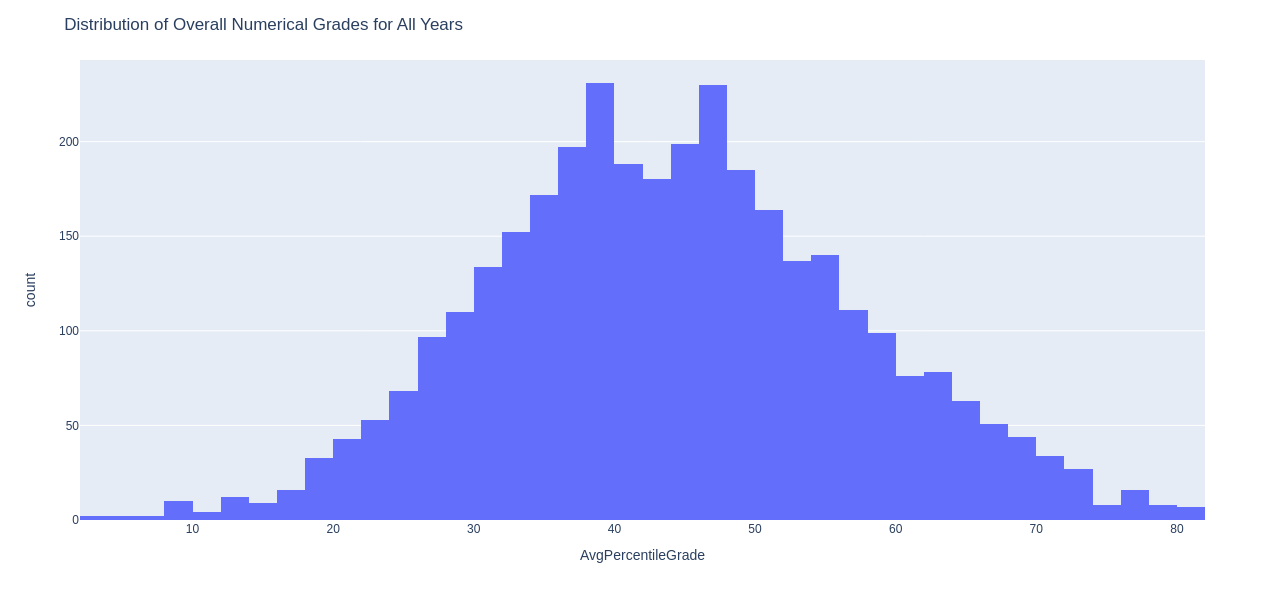

In [67]:
fig = px.histogram(
    grades_df,
    x="AvgPercentileGrade",
)

fig.update_layout(
    width=1200,
    height=600,
    title=f"Distribution of Overall Numerical Grades for All Years",
)

fig.show()

In [68]:
from src.data.scripts.grade_buildings import bins, letter_grades

In [69]:
grades_df["AvgPercentileLetterGrade"] = pd.cut(
    grades_df["AvgPercentileGrade"],
    bins=bins,
    labels=letter_grades,
    right=True
)

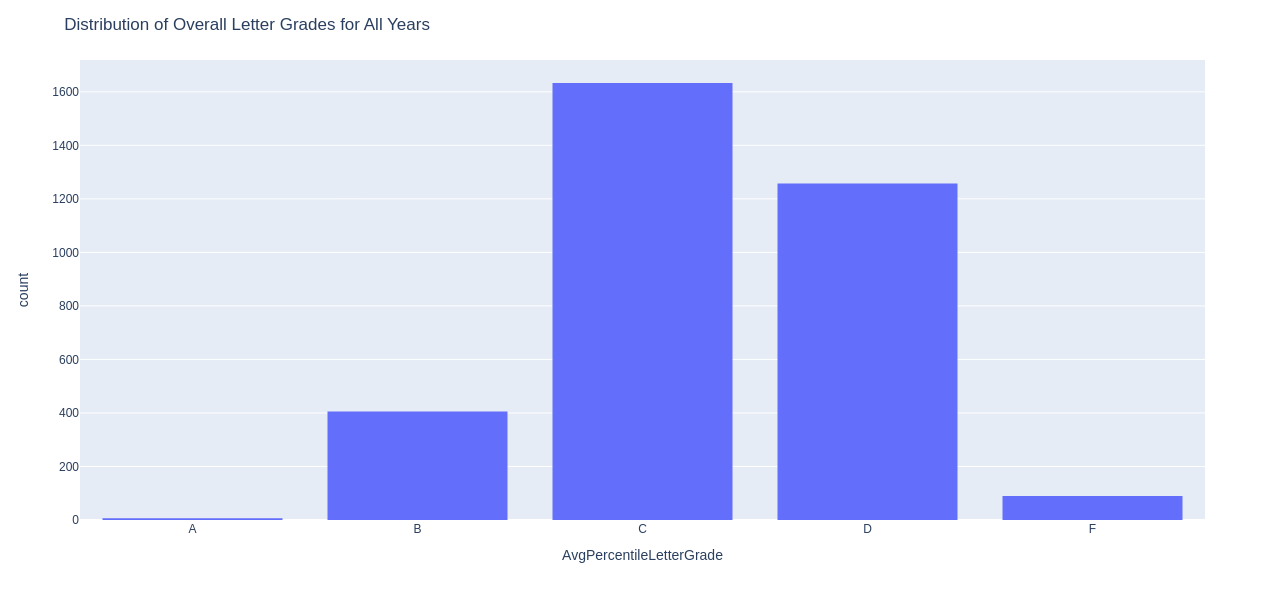

In [70]:
fig = px.histogram(
    grades_df,
    "AvgPercentileLetterGrade",
)

fig.update_layout(
    width=1200,
    height=600,
    title=f"Distribution of Overall Letter Grades for All Years",
    xaxis={'categoryorder': 'category ascending'},
)

fig.show()

Explore overall grades a bit more.

In [71]:
building_of_interest = "Crown Hall"
grades_df[grades_df["PropertyName"] == building_of_interest]

DataYear      ID PropertyName ReportingStatus              Address  \
3192      2021  256419   Crown Hall       Submitted  3360 S State Street   

     ZIPCode  ChicagoEnergyRating ExemptFromChicagoEnergyRating CommunityArea  \
3192   60616               1.0000                         False       DOUGLAS   

     PrimaryPropertyType  ...  GHGIntensityPercentileGrade  \
3192  College/University  ...                       0.0000   

      GHGIntensityLetterGrade  EnergyMixWeightedPctSum  \
3192                        F                 100.2947   

      EnergyMixWeightedPctSumPercentileGrade  \
3192                                 42.1053   

      EnergyMixWeightedPctSumLetterGrade  MissingRecordsCount  \
3192                                   C                    2   

      MissingRecordsCountPercentileGrade  SubmittedRecordsGrade  \
3192                             12.4300                      C   

      AvgPercentileGrade  AvgPercentileLetterGrade  
3192             18.1784                         F  

[1 rows x 66 columns]

In [72]:
building_of_interest = "Keating Hall"
grades_df[grades_df["PropertyName"] == building_of_interest]

DataYear      ID  PropertyName ReportingStatus               Address  \
3204      2021  256434  Keating Hall       Submitted  3040 S Wabash Avenue   

     ZIPCode  ChicagoEnergyRating ExemptFromChicagoEnergyRating CommunityArea  \
3204   60616               2.0000                         False       DOUGLAS   

     PrimaryPropertyType  ...  GHGIntensityPercentileGrade  \
3204  College/University  ...                       1.5038   

      GHGIntensityLetterGrade  EnergyMixWeightedPctSum  \
3204                        F                  54.3540   

      EnergyMixWeightedPctSumPercentileGrade  \
3204                                  1.5038   

      EnergyMixWeightedPctSumLetterGrade  MissingRecordsCount  \
3204                                   F                    2   

      MissingRecordsCountPercentileGrade  SubmittedRecordsGrade  \
3204                             12.4300                      C   

      AvgPercentileGrade  AvgPercentileLetterGrade  
3204              5.1458                         F  

[1 rows x 66 columns]

In [73]:
building_of_interest = "Merchandise Mart"
grades_df[grades_df["PropertyName"] == building_of_interest]

DataYear      ID      PropertyName ReportingStatus  \
334      2022  103656  Merchandise Mart  Submitted Data   

                      Address ZIPCode  ChicagoEnergyRating  \
334  222 Merchandise Mart Plz   60654                  NaN   

    ExemptFromChicagoEnergyRating    CommunityArea PrimaryPropertyType  ...  \
334                          True  NEAR NORTH SIDE              Office  ...   

     GHGIntensityPercentileGrade  GHGIntensityLetterGrade  \
334                      79.7175                        B   

     EnergyMixWeightedPctSum  EnergyMixWeightedPctSumPercentileGrade  \
334                 123.9212                                 69.6744   

     EnergyMixWeightedPctSumLetterGrade  MissingRecordsCount  \
334                                   B                    0   

     MissingRecordsCountPercentileGrade  SubmittedRecordsGrade  \
334                             43.8250                      A   

     AvgPercentileGrade  AvgPercentileLetterGrade  
334             64.4056                         B  

[1 rows x 66 columns]

In [74]:
building_of_interest = "Marina Towers Condominium Association"
grades_df[grades_df["PropertyName"] == building_of_interest]

DataYear      ID                           PropertyName ReportingStatus  \
1923      2022  239096  Marina Towers Condominium Association  Submitted Data   

             Address ZIPCode  ChicagoEnergyRating  \
1923  300 N State St   60654               3.0000   

     ExemptFromChicagoEnergyRating    CommunityArea  PrimaryPropertyType  ...  \
1923                         False  NEAR NORTH SIDE  Multifamily Housing  ...   

      GHGIntensityPercentileGrade  GHGIntensityLetterGrade  \
1923                      64.5743                        B   

      EnergyMixWeightedPctSum  EnergyMixWeightedPctSumPercentileGrade  \
1923                 200.0000                                100.0000   

      EnergyMixWeightedPctSumLetterGrade  MissingRecordsCount  \
1923                                   A                    0   

      MissingRecordsCountPercentileGrade  SubmittedRecordsGrade  \
1923                             43.8250                      A   

      AvgPercentileGrade  AvgPercentileLetterGrade  
1923             69.4665                         B  

[1 rows x 66 columns]

In [75]:
# All the A buildings:
grades_df[grades_df["AvgPercentileLetterGrade"] == "A"]

DataYear      ID                                 PropertyName  \
690       2022  117024                                          NaN   
798       2022  124236                           830 N Michigan Ave   
1243      2022  160142        U.S. Cellular Plaza - 8430 _ Goby LLC   
1398      2022  165717        Moody Bible Institute, Solheim Center   
1448      2022  172137  Newberry Plaza Townhouse Owners Association   
2662      2022  251770        U.S. Cellular Plaza - 8420 _ Goby LLC   
2925      2022  254001                                          NaN   

     ReportingStatus                 Address ZIPCode  ChicagoEnergyRating  \
690   Submitted Data  1830  N WINCHESTER AVE   60622               4.0000   
798   Submitted Data      830 N Michigan Ave   60611               4.0000   
1243  Submitted Data    8430 W Bryn Mawr Ave   60631               4.0000   
1398  Submitted Data          930 N Wells St   60610               4.0000   
1448  Submitted Data         1000 N STATE ST   60610               4.0000   
2662  Submitted Data    8420 W Bryn Mawr Ave   60631               4.0000   
2925  Submitted Data   4434 4444 N Damen Ave   60625               4.0000   

     ExemptFromChicagoEnergyRating    CommunityArea  PrimaryPropertyType  ...  \
690                          False     LOGAN SQUARE  Multifamily Housing  ...   
798                          False  NEAR NORTH SIDE               Office  ...   
1243                         False            OHARE               Office  ...   
1398                         False  NEAR NORTH SIDE   College/University  ...   
1448                         False  NEAR NORTH SIDE  Multifamily Housing  ...   
2662                         False            OHARE               Office  ...   
2925                         False     North Center  Multifamily Housing  ...   

      GHGIntensityPercentileGrade  GHGIntensityLetterGrade  \
690                       99.8823                        A   
798                       99.0585                        A   
1243                      97.3715                        A   
1398                      97.0184                        A   
1448                      97.3715                        A   
2662                      99.9215                        A   
2925                      97.0184                        A   

      EnergyMixWeightedPctSum  EnergyMixWeightedPctSumPercentileGrade  \
690                  200.0000                                100.0000   
798                  200.0000                                100.0000   
1243                 200.0000                                100.0000   
1398                 200.0000                                100.0000   
1448                 200.0000                                100.0000   
2662                 200.0000                                100.0000   
2925                 200.0000                                100.0000   

      EnergyMixWeightedPctSumLetterGrade  MissingRecordsCount  \
690                                    A                    0   
798                                    A                    0   
1243                                   A                    0   
1398                                   A                    0   
1448                                   A                    0   
2662                                   A                    0   
2925                                   A                    0   

      MissingRecordsCountPercentileGrade  SubmittedRecordsGrade  \
690                              43.8250                      A   
798                              43.8250                      A   
1243                             43.8250                      A   
1398                             43.8250                      A   
1448                             43.8250                      A   
2662                             43.8250                      A   
2925                             43.8250                      A   

      AvgPercentileGrade  AvgPe

Check that there are no NA's in grading columns

In [81]:
grades_df[grades_columns].isna().sum()

AvgPercentileGrade                        0
AvgPercentileLetterGrade                  0
EnergyMixWeightedPctSum                   0
EnergyMixWeightedPctSumLetterGrade        0
EnergyMixWeightedPctSumPercentileGrade    0
GHGIntensityLetterGrade                   0
GHGIntensityPercentileGrade               0
MissingRecordsCount                       0
MissingRecordsCountPercentileGrade        0
SubmittedRecordsGrade                     0
dtype: int64